#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA-II/NSGA-III/MOEA/D; except for NSGA).
- Note that it has to be your implementation (using external libraries is forbidden; EXCEPTION: you can use the JECDM framework: https://jecdm.cs.put.poznan.pl -- but it is a relatively complex software, and much effort must be spent to understand how to use it).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, tackle also a three-objective one. As for the third objective, think about some reasonable risk-measure. E.g., you can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

# Lab 1

Import the necessary libraries (numpy, pandas, matplotlib, cvxopt).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.linear_model import Lasso
from scipy.signal import savgol_filter

# For reproducible randomness
np.random.seed(42)

Load the data from *Part1.txt files. Each file’s first line is the asset name, second line is N, and then N lines with “time price”.

In [2]:
def load_asset_data(data_folder="Bundle3"):
    asset_names = []
    asset_times = []
    asset_prices = []
    
    txt_files = [f for f in os.listdir(data_folder) if f.endswith("Part3.txt")]
    
    for fname in txt_files:
        path = os.path.join(data_folder, fname)
        with open(path, "r") as f:
            # 1) asset name
            asset_name = f.readline().strip()
    
            # 2) number of data points
            N_line = f.readline().strip()
            N = int(N_line)
    
            # 3) read time, price lines
            times = []
            prices = []
            for _ in range(N):
                line = f.readline().strip()
                t_str, p_str = line.split()
                times.append(float(t_str))
                prices.append(float(p_str))
    
            asset_names.append(asset_name)
            asset_times.append(times)
            asset_prices.append(prices)
    
    print(f"Found {len(asset_names)} assets.")
    print("First few asset names:", asset_names[:5])
    return asset_names, asset_times, asset_prices

asset_names, asset_times, asset_prices = load_asset_data()

Found 20 assets.
First few asset names: ['SafeAndCare', 'Fuel4', 'Moneymakers', 'MarsProject', 'CPU-XYZ']


Looking for files with suffix: Part3.txt
Found 20 files to process
Processing asset: SafeAndCare
  Market trend: downward, Position: near_trough
  Volatility: 0.2518
  Average cycle length: 15.53
  Tried HoltWinters: MSE = 0.1424
  Tried DampedSin: MSE = 0.2739
  Selected HoltWinters model with MSE: 0.1424
  Applying market-aware mean reversion (strength=0.60)
  Near market trough with downward forecast - increasing reversion
Processing asset: Fuel4
  Market trend: downward, Position: near_trough
  Volatility: 0.1083
  Average cycle length: 12.08
  Tried HoltWinters: MSE = 0.4666
  Tried DampedSin: MSE = 0.1591
  Selected DampedSin model with MSE: 0.1591
  Applying market-aware mean reversion (strength=0.60)
  Near market trough with downward forecast - increasing reversion
Processing asset: Moneymakers
  Market trend: upward, Position: near_peak
  Volatility: 0.1811
  Average cycle length: 12.48
  Tried HoltWinters: MSE = 0.2973
  Tried DampedSin: MSE = 0.2975
  Selected HoltWinters m

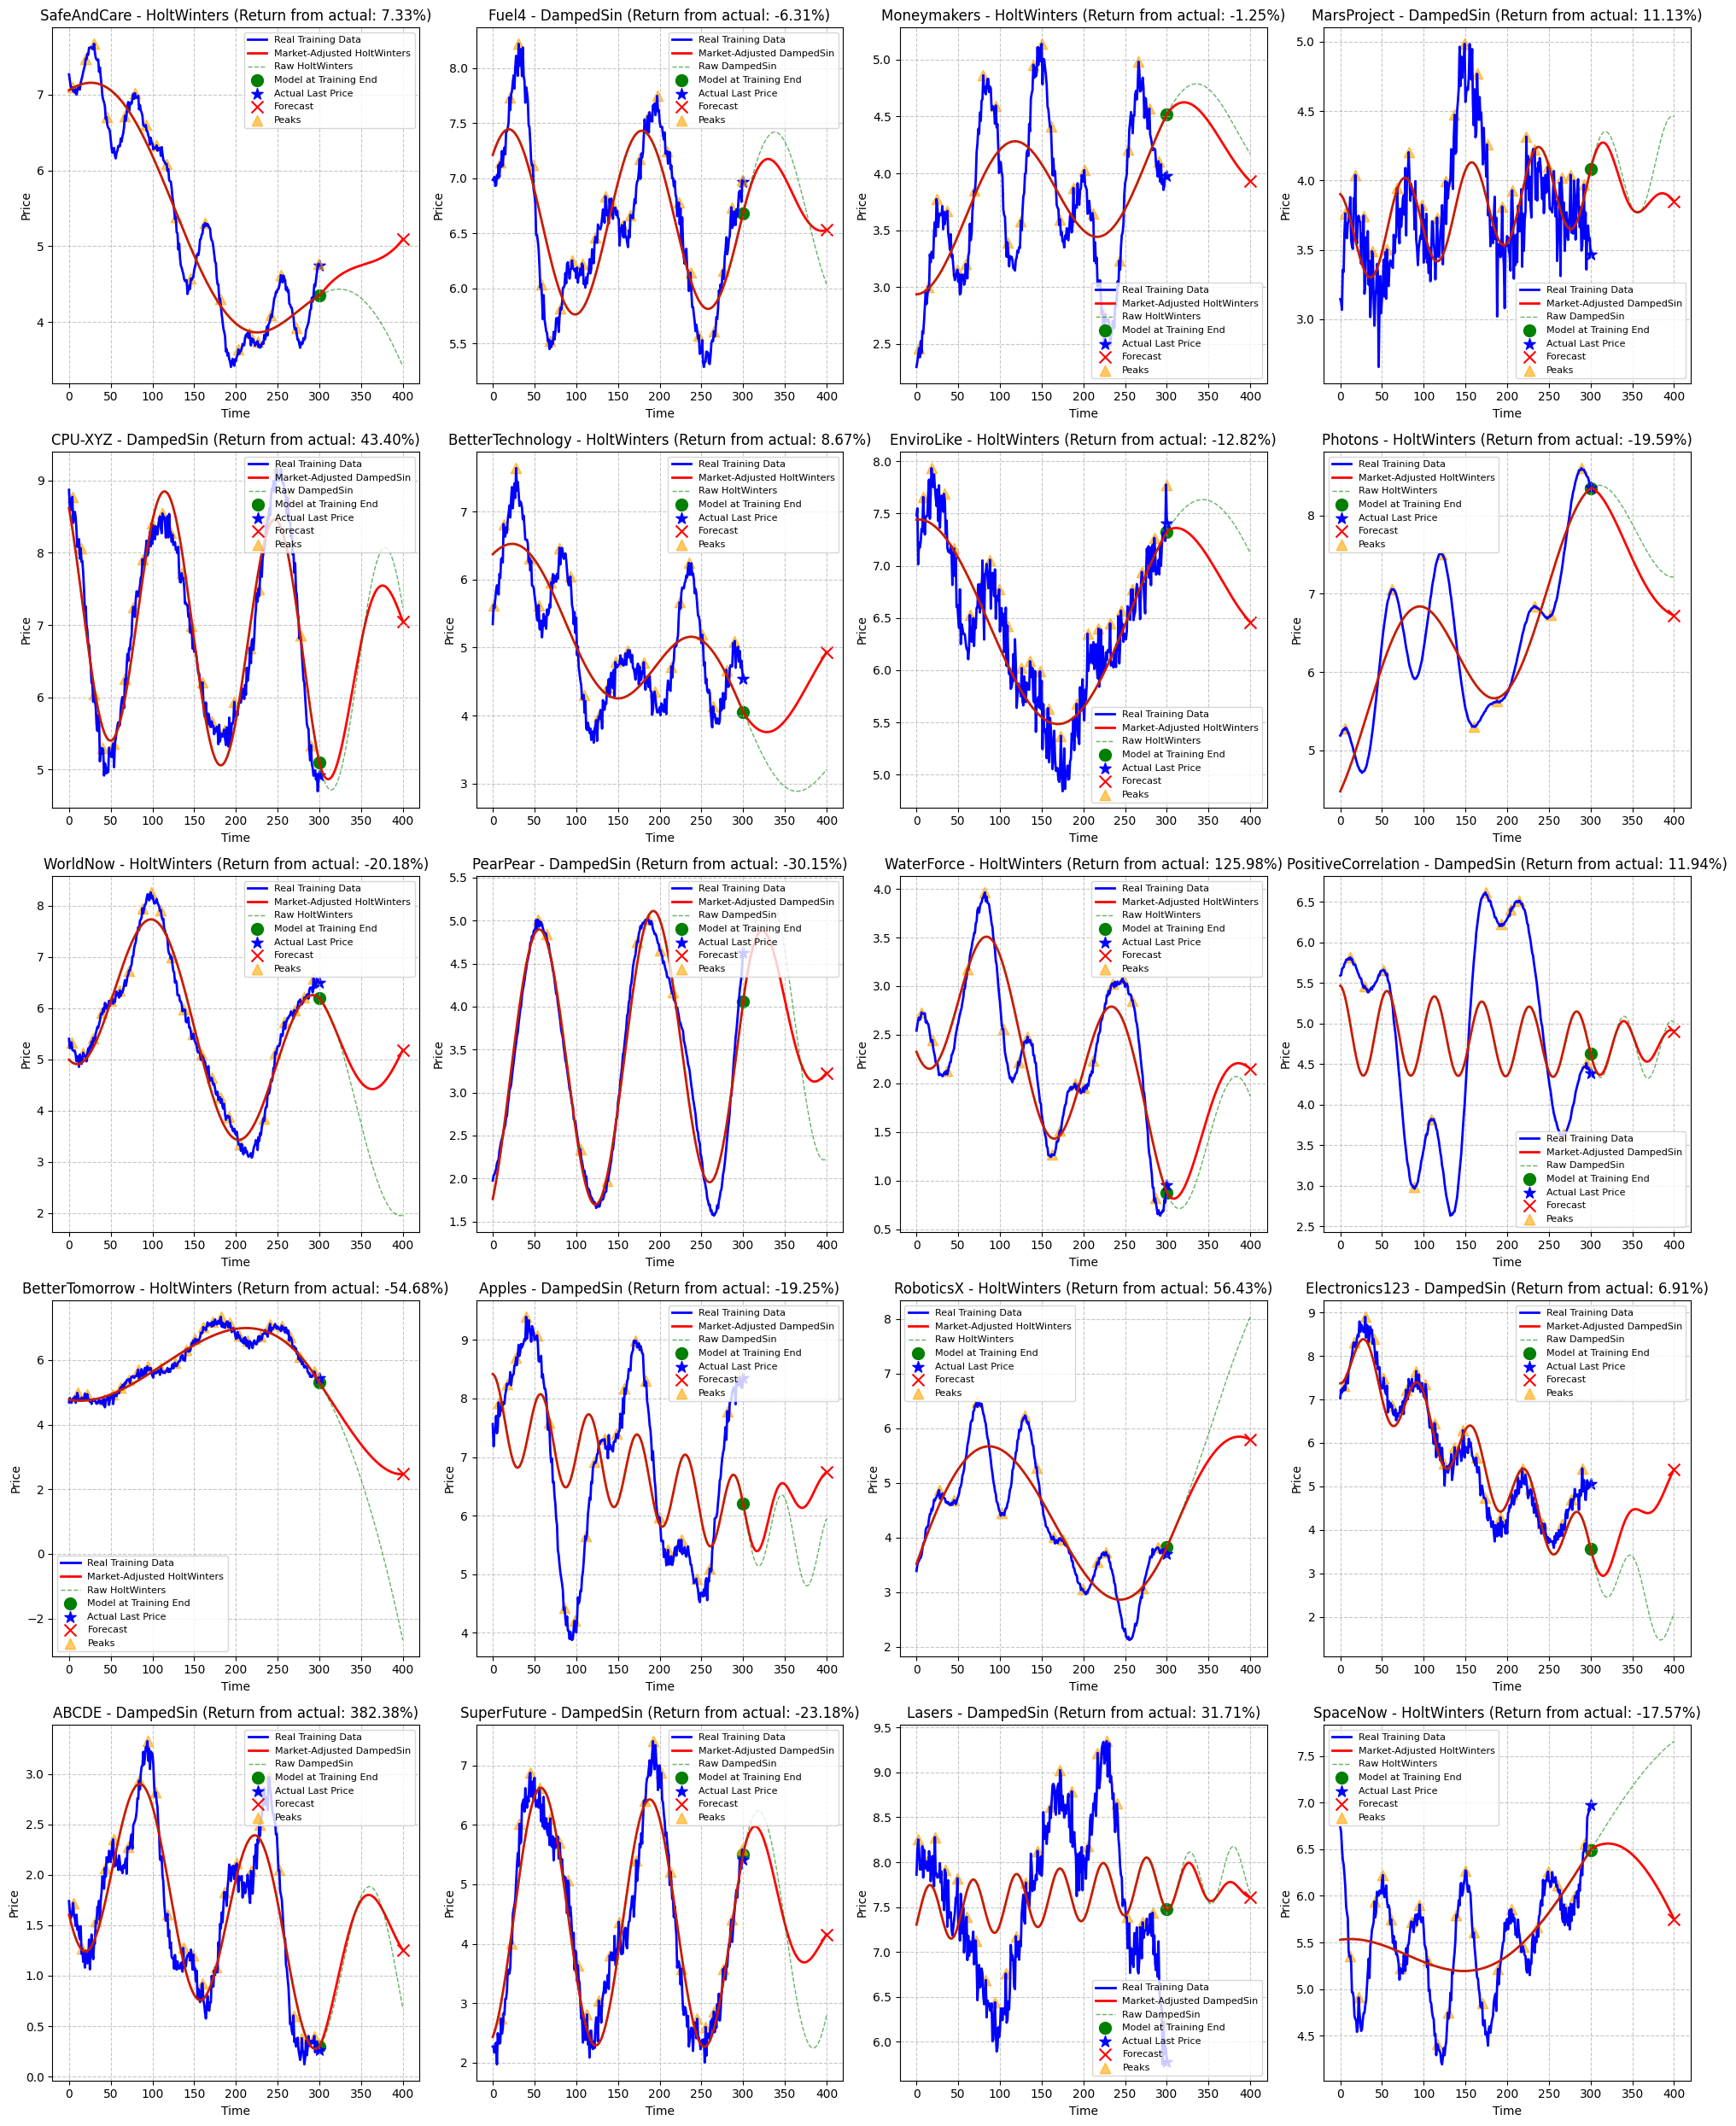


Summary of Market-Aware Predictions for Each Asset:
Asset                Best Model          Actual Last  Forecast Price Expected Return
--------------------------------------------------------------------------------
SafeAndCare          HoltWinters              4.7415          5.0889            7.33%
Fuel4                DampedSin                6.9718          6.5322           -6.31%
Moneymakers          HoltWinters              3.9796          3.9297           -1.25%
MarsProject          DampedSin                3.4653          3.8510           11.13%
CPU-XYZ              DampedSin                4.9187          7.0534           43.40%
BetterTechnology     HoltWinters              4.5392          4.9327            8.67%
EnviroLike           HoltWinters              7.4088          6.4588          -12.82%
Photons              HoltWinters              8.3571          6.7204          -19.59%
WorldNow             HoltWinters              6.4900          5.1804          -20.18%
PearPea

In [3]:
from stock_predictor import StockPredictor

# Create an instance with your data folder - works with any bundle number
# Examples: "Bundle2", "Bundle3", etc.
sp = StockPredictor(data_folder="Bundle3")  # Change to your actual data folder

# Generate and plot market-aware predictions that account for market cycles
market_predictions = sp.plot_market_aware_predictions(
    training_start=0,
    training_end=None,  # Will default to the last available time point
    forecast_time=None, # Will default to training_end + 100
    show_raw=True       # Show both raw model and market-adjusted forecasts
)

# The market_predictions variable now contains the curve fit results for each asset
# Example of accessing a specific asset's prediction:
# asset_prediction = market_predictions["AssetName"]
# print(asset_prediction["model_name"])         # The selected model
# print(asset_prediction["predicted_return"])   # The forecasted return percentage
# print(asset_prediction["market_info"])        # Market cycle information

### Markowitz Model using **mean** results

In [4]:
# Extract expected returns from mean results
expected_returns = np.array([market_predictions[asset]["predicted_return"] / 100.0 for asset in asset_names])
n_assets = len(asset_names)

# Compute covariance matrix using historical data
historical_returns = []
for i, asset in enumerate(asset_names):
    # Get prices during training period
    prices = np.array(asset_prices[i])
    times = np.array(asset_times[i])
    mask = (times >= 0) & (times <= 100)
    asset_prices_train = prices[mask]
    
    # Calculate returns
    asset_returns = np.diff(asset_prices_train) / asset_prices_train[:-1]
    historical_returns.append(asset_returns)

# Ensure all historical returns have the same length
min_length = min(len(returns) for returns in historical_returns)
historical_returns = [returns[:min_length] for returns in historical_returns]
historical_returns = np.array(historical_returns)

# Compute covariance matrix
cov_matrix = np.cov(historical_returns)

# Ensure covariance matrix is positive semi-definite
eigenvalues = np.linalg.eigvalsh(cov_matrix)
if np.any(eigenvalues < 0):
    cov_matrix += np.eye(n_assets) * 1e-8

print("Expected Returns (sample):")
for i in range(min(5, n_assets)):
    print(f"{asset_names[i]}: {expected_returns[i]:.4f}")

print("\nCovariance Matrix (sample):")
print(cov_matrix[:3, :3])

# Find minimum risk portfolio
def solve_min_risk():
    """Find the portfolio with minimum risk"""
    P = matrix(cov_matrix)
    q = matrix(np.zeros(n_assets))
    
    # Constraint: w ≥ 0
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    # Constraint: sum(w) = 1
    A = matrix(np.ones((1, n_assets)))
    b = matrix(np.ones(1))
    
    sol = solvers.qp(P, q, G, h, A, b)
    weights = np.array(sol['x']).flatten()
    port_return = np.dot(weights, expected_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return weights, port_risk, port_return

# Find maximum return portfolio
def solve_max_return():
    """Find the portfolio with maximum return"""
    c = matrix(-expected_returns)  # Negative because we minimize -r^T w
    
    # Constraint: w ≥ 0
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    # Constraint: sum(w) = 1
    A = matrix(np.ones((1, n_assets)))
    b = matrix(np.ones(1))
    
    sol = solvers.lp(c, G, h, A, b)
    weights = np.array(sol['x']).flatten()
    port_return = np.dot(weights, expected_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return weights, port_return, port_risk

# Find the extreme portfolios
min_risk_weights, min_risk_value, min_risk_return = solve_min_risk()
max_return_weights, max_return_value, max_return_risk = solve_max_return()

print("\nMinimum Risk Portfolio:")
print(f"Risk: {min_risk_value:.6f}")
print(f"Return: {min_risk_return:.6f}")

print("\nMaximum Return Portfolio:")
print(f"Return: {max_return_value:.6f}")
print(f"Risk: {max_return_risk:.6f}")

Expected Returns (sample):
SafeAndCare: 0.0733
Fuel4: -0.0631
Moneymakers: -0.0125
MarsProject: 0.1113
CPU-XYZ: 0.4340

Covariance Matrix (sample):
[[ 1.01854023e-04 -1.71112855e-05  6.69455358e-05]
 [-1.71112855e-05  2.97224717e-04  1.45858732e-04]
 [ 6.69455358e-05  1.45858732e-04  1.24950579e-03]]
     pcost       dcost       gap    pres   dres
 0:  3.0411e-05 -1.0000e+00  1e+00  2e-16  5e+00
 1:  3.0400e-05 -1.0040e-02  1e-02  6e-17  5e-02
 2:  2.9347e-05 -1.3904e-04  2e-04  5e-17  8e-04
 3:  1.5808e-05 -1.9400e-05  4e-05  3e-16  1e-04
 4:  6.5780e-06 -3.3258e-06  1e-05  3e-16  5e-20
 5:  5.2131e-06  3.7689e-06  1e-06  4e-16  3e-20
 6:  4.8912e-06  4.7553e-06  1e-07  2e-16  2e-20
 7:  4.8531e-06  4.8448e-06  8e-09  4e-17  2e-20
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.4045e-01 -2.4045e-01  5e+00  2e-16  5e+00  1e+00
 1: -2.7357e+00 -3.0446e+00  2e+00  2e-16  2e+00  1e-01
 2: -3.7347e+00 -3.7486e+00  1e-01  2e-16  9e-02  5e-03
 3: -3.8229e

### Implementation of the two multi-objective methods:
- **Weighted Sum Method (WSM)**  
- **Epsilon-Constraint Method (ECM)**  

WSM found 15 unique solutions
ECM found 10 unique solutions


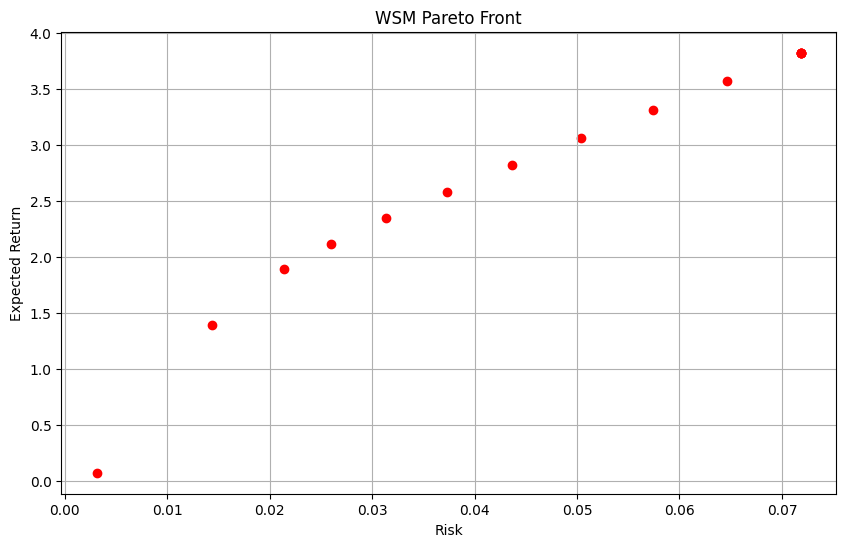

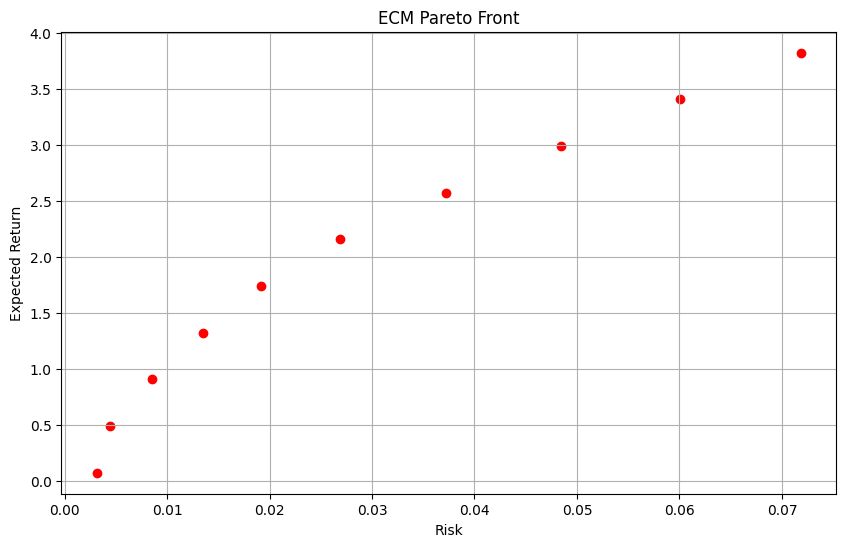

In [5]:
# Suppress solver output
solvers.options['show_progress'] = False

# Weighted Sum Method (WSM)
def weighted_sum_method(n_weights=10, normalize=True):
    # Set up normalization ranges if needed
    if normalize:
        return_range = max_return_value - min_risk_return
        risk_range = max_return_risk - min_risk_value
    
    # Generate weight vectors
    weight_vectors = []
    for i in range(n_weights):
        w_return = i / (n_weights - 1)  # Weight for return
        w_risk = 1 - w_return           # Weight for risk
        weight_vectors.append((w_return, w_risk))
    
    # Solve for each weight vector
    solutions = []
    for w_return, w_risk in weight_vectors:
        # Setup quadratic programming parameters
        P = matrix(cov_matrix)
        q = matrix(np.zeros(n_assets))
        
        if normalize:
            # For normalized objective function
            q_mod = matrix(-w_return * expected_returns / return_range)
            P_mod = matrix(w_risk * cov_matrix / risk_range)
        else:
            # For non-normalized objective function
            q_mod = matrix(-w_return * expected_returns)
            P_mod = matrix(w_risk * cov_matrix)
        
        # Constraint: w ≥ 0
        G = matrix(-np.eye(n_assets))
        h = matrix(np.zeros(n_assets))
        
        # Constraint: sum(w) = 1
        A = matrix(np.ones((1, n_assets)))
        b = matrix(np.ones(1))
        
        # Solve QP
        sol = solvers.qp(P_mod, q_mod, G, h, A, b)
        
        if sol['status'] != 'optimal':
            print(f"Warning: Optimization did not reach an optimal solution for weights {w_return}, {w_risk}. Status: {sol['status']}")
            continue
        
        weights = np.array(sol['x']).flatten()
        port_return = np.dot(weights, expected_returns)
        port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        solutions.append((weights, port_return, port_risk))
    
    # Filter duplicate solutions
    unique_solutions = []
    for sol in solutions:
        is_unique = True
        for existing_sol in unique_solutions:
            if (np.abs(sol[1] - existing_sol[1]) < 1e-6 and 
                np.abs(sol[2] - existing_sol[2]) < 1e-6):
                is_unique = False
                break
        if is_unique:
            unique_solutions.append(sol)
    
    return unique_solutions

# Epsilon-Constraint Method (ECM)
def epsilon_constraint_method(n_thresholds=10):
    """
    Implements the Epsilon-Constraint Method for portfolio optimization.
    
    Args:
        n_thresholds: Number of threshold values to use
    
    Returns:
        List of Pareto optimal solutions (weights, return, risk)
    """
    # Generate threshold values
    thresholds = []
    for i in range(n_thresholds):
        t = min_risk_return + (i / (n_thresholds - 1)) * (max_return_value - min_risk_return)
        thresholds.append(t)
    
    # Solve for each threshold
    solutions = []
    for threshold in thresholds:
        # Setup quadratic programming parameters
        P = matrix(cov_matrix)
        q = matrix(np.zeros(n_assets))
        
        # Constraint: w ≥ 0
        G = matrix(-np.eye(n_assets))
        h = matrix(np.zeros(n_assets))
        
        # Constraints: sum(w) = 1 and r^T w >= threshold
        A = matrix(np.vstack((
            np.ones(n_assets),     # sum(w) = 1
            expected_returns       # r^T w >= threshold
        )))
        b = matrix(np.array([1.0, threshold]))
        
        # Solve QP
        sol = solvers.qp(P, q, G, h, A, b)
        
        if sol['status'] != 'optimal':
            print(f"Warning: Optimization did not reach an optimal solution for threshold {threshold}. Status: {sol['status']}")
            continue
        
        weights = np.array(sol['x']).flatten()
        port_return = np.dot(weights, expected_returns)
        port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        solutions.append((weights, port_return, port_risk))
    
    # Filter duplicate solutions
    unique_solutions = []
    for sol in solutions:
        is_unique = True
        for existing_sol in unique_solutions:
            if (np.abs(sol[1] - existing_sol[1]) < 1e-6 and 
                np.abs(sol[2] - existing_sol[2]) < 1e-6):
                is_unique = False
                break
        if is_unique:
            unique_solutions.append(sol)
    
    return unique_solutions

# Function to plot Pareto front
def plot_pareto_front(solutions, title):
    risks = [sol[2] for sol in solutions]
    returns = [sol[1] for sol in solutions]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(risks, returns, c='red', marker='o')
    plt.xlabel('Risk')
    plt.ylabel('Expected Return')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Test the methods with a small number of points
wsm_solutions = weighted_sum_method(100)
ecm_solutions = epsilon_constraint_method(10)

print(f"WSM found {len(wsm_solutions)} unique solutions")
print(f"ECM found {len(ecm_solutions)} unique solutions")

plot_pareto_front(wsm_solutions, "WSM Pareto Front")
plot_pareto_front(ecm_solutions, "ECM Pareto Front")

# Lab 2

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

# Seed for reproducibility
np.random.seed(42)
random.seed(42)

class NSGA2:
    def __init__(self, n_assets, expected_returns, cov_matrix, 
                 pop_size=100, max_gen=100, crossover_prob=0.9, mutation_prob=0.1,
                 tournament_size=2, mutation_strength=0.1, n_objectives=2):
        self.n_assets = n_assets
        self.expected_returns = expected_returns
        self.cov_matrix = cov_matrix
        self.pop_size = pop_size
        self.max_gen = max_gen
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.tournament_size = tournament_size
        self.mutation_strength = mutation_strength
        self.n_objectives = n_objectives
        
        # For tracking metrics
        self.hypervolume_history = []
        self.igd_history = []
        self.reference_point = None
    
    def initialize_population(self):
        population = []
        
        for _ in range(self.pop_size):
            # Generate random weights
            weights = np.random.random(self.n_assets)
            weights /= np.sum(weights)  # Normalize to sum to 1
            
            # Evaluate objectives
            objectives = self.evaluate_objectives(weights)
            
            # Create individual
            individual = {
                'weights': weights,
                'objectives': objectives,
                'rank': None,
                'crowding_distance': None
            }
            
            population.append(individual)
        
        return population
    
    def evaluate_objectives(self, weights):
        # Expected return (we negate it because we're minimizing)
        expected_return = -np.dot(weights, self.expected_returns)
        
        # Risk (standard deviation)
        risk = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        
        if self.n_objectives == 2:
            return np.array([expected_return, risk])
        
        # Diversification measure (negative because we want to maximize)
        # Count number of assets with significant weight (>1%)
        diversification = -np.sum(weights > 0.01)
        
        return np.array([expected_return, risk, diversification])
    
    def dominates(self, ind1, ind2):
        # ind1 dominates ind2 if:
        # 1. ind1 is no worse than ind2 in all objectives
        # 2. ind1 is strictly better than ind2 in at least one objective
        
        obj1 = ind1['objectives']
        obj2 = ind2['objectives']
        
        no_worse = np.all(obj1 <= obj2)
        strictly_better = np.any(obj1 < obj2)
        
        return no_worse and strictly_better
    
    def fast_non_dominated_sort(self, population):
        # Initialize with first front
        fronts = []
        first_front = []
        
        # For each individual
        for i, p in enumerate(population):
            p['domination_count'] = 0  # Number of solutions that dominate p
            p['dominated_solutions'] = []  # Set of solutions that p dominates
            
            for j, q in enumerate(population):
                if i == j:
                    continue
                    
                if self.dominates(p, q):
                    p['dominated_solutions'].append(j)
                elif self.dominates(q, p):
                    p['domination_count'] += 1
            
            if p['domination_count'] == 0:
                p['rank'] = 0  # Rank of the first front
                first_front.append(i)
        
        # Add first front if not empty
        if first_front:
            fronts.append(first_front)
        else:
            # If no non-dominated solutions found, add the best one
            # This is a fallback to prevent empty fronts
            min_dom_count = float('inf')
            min_dom_idx = 0
            for i, p in enumerate(population):
                if p['domination_count'] < min_dom_count:
                    min_dom_count = p['domination_count']
                    min_dom_idx = i
            
            if min_dom_count < float('inf'):
                population[min_dom_idx]['rank'] = 0
                fronts.append([min_dom_idx])
        
        # Find subsequent fronts
        i = 0
        while i < len(fronts):  # Safe check against fronts length
            next_front = []
            
            for p_idx in fronts[i]:
                p = population[p_idx]
                
                for q_idx in p['dominated_solutions']:
                    q = population[q_idx]
                    q['domination_count'] -= 1
                    
                    if q['domination_count'] == 0:
                        q['rank'] = i + 1
                        next_front.append(q_idx)
            
            i += 1
            if next_front:
                fronts.append(next_front)
        
        return fronts
    
    def calculate_crowding_distance(self, population, front):
        if len(front) <= 2:
            for idx in front:
                population[idx]['crowding_distance'] = float('inf')
            return
        
        n_objectives = len(population[0]['objectives'])
        
        for idx in front:
            population[idx]['crowding_distance'] = 0
        
        for obj_idx in range(n_objectives):
            # Sort the front by the objective value
            front_sorted = sorted(front, key=lambda x: population[x]['objectives'][obj_idx])
            
            # Set boundary points to infinity
            population[front_sorted[0]]['crowding_distance'] = float('inf')
            population[front_sorted[-1]]['crowding_distance'] = float('inf')
            
            # Calculate crowding distance for other points
            obj_range = (population[front_sorted[-1]]['objectives'][obj_idx] - 
                         population[front_sorted[0]]['objectives'][obj_idx])
            
            if obj_range == 0:
                continue  # Skip if all values are the same
                
            for i in range(1, len(front_sorted) - 1):
                distance = (population[front_sorted[i+1]]['objectives'][obj_idx] - 
                           population[front_sorted[i-1]]['objectives'][obj_idx]) / obj_range
                
                population[front_sorted[i]]['crowding_distance'] += distance
    
    def tournament_selection(self, population, k=2):
        # Ensure k is not larger than population size
        k = min(k, len(population))
        
        # Select k random individuals
        candidates = random.sample(population, k)
        
        # Find the best by comparing rank first, then crowding distance
        best = candidates[0]
        
        for candidate in candidates[1:]:
            # Handle case where rank might be None
            if candidate['rank'] is None and best['rank'] is None:
                # If both ranks are None, use crowding distance
                if candidate['crowding_distance'] > best['crowding_distance']:
                    best = candidate
            elif candidate['rank'] is None:
                continue  # Keep best if candidate rank is None
            elif best['rank'] is None:
                best = candidate  # Replace if best rank is None
            # Normal comparison
            elif candidate['rank'] < best['rank']:
                best = candidate
            elif candidate['rank'] == best['rank'] and candidate['crowding_distance'] > best['crowding_distance']:
                best = candidate
        
        return best
    
    def simulated_binary_crossover(self, parent1, parent2, eta=1):
        p1 = parent1['weights'].copy()
        p2 = parent2['weights'].copy()
        
        # Apply SBX
        if random.random() <= self.crossover_prob:
            child1 = np.zeros_like(p1)
            child2 = np.zeros_like(p2)
            
            for i in range(len(p1)):
                if random.random() <= 0.5:
                    if abs(p1[i] - p2[i]) > 1e-10:
                        if p1[i] < p2[i]:
                            y1, y2 = p1[i], p2[i]
                        else:
                            y1, y2 = p2[i], p1[i]
                        
                        beta = 1.0 + (2.0 * (y1 - 0.0)) / (y2 - y1)
                        alpha = 2.0 - beta ** (-(eta + 1.0))
                        
                        rand = random.random()
                        if rand <= 1.0 / alpha:
                            beta_q = (rand * alpha) ** (1.0 / (eta + 1.0))
                        else:
                            beta_q = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
                        
                        c1 = 0.5 * ((y1 + y2) - beta_q * (y2 - y1))
                        c2 = 0.5 * ((y1 + y2) + beta_q * (y2 - y1))
                        
                        c1 = max(0.0, min(1.0, c1))
                        c2 = max(0.0, min(1.0, c2))
                        
                        child1[i] = c1
                        child2[i] = c2
                    else:
                        child1[i] = p1[i]
                        child2[i] = p2[i]
                else:
                    child1[i] = p1[i]
                    child2[i] = p2[i]
        else:
            child1 = p1.copy()
            child2 = p2.copy()
        
        # Normalize to sum to 1
        child1 /= np.sum(child1)
        child2 /= np.sum(child2)
        
        return child1, child2
    
    def polynomial_mutation(self, individual, eta=20):
        mutated = individual.copy()
        
        for i in range(len(mutated)):
            if random.random() <= self.mutation_prob:
                # Get the boundaries
                lb, ub = 0.0, 1.0
                
                # Apply polynomial mutation
                delta1 = (mutated[i] - lb) / (ub - lb)
                delta2 = (ub - mutated[i]) / (ub - lb)
                
                rand = random.random()
                mut_pow = 1.0 / (eta + 1.0)
                
                if rand <= 0.5:
                    xy = 1.0 - delta1
                    val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta + 1.0))
                    deltaq = val ** mut_pow - 1.0
                else:
                    xy = 1.0 - delta2
                    val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta + 1.0))
                    deltaq = 1.0 - val ** mut_pow
                
                mutated[i] += deltaq * (ub - lb)
                mutated[i] = max(lb, min(ub, mutated[i]))
        
        # Normalize to sum to 1
        mutated /= np.sum(mutated)
        
        return mutated
    
    def create_offspring(self, population):
        offspring = []
        
        for _ in range(self.pop_size):
            # Tournament selection
            parent1 = self.tournament_selection(population, self.tournament_size)
            parent2 = self.tournament_selection(population, self.tournament_size)
            
            # Crossover
            child1_weights, child2_weights = self.simulated_binary_crossover(parent1, parent2)
            
            # Mutation
            child1_weights = self.polynomial_mutation(child1_weights)
            child2_weights = self.polynomial_mutation(child2_weights)
            
            # Evaluate objectives
            child1_objectives = self.evaluate_objectives(child1_weights)
            child2_objectives = self.evaluate_objectives(child2_weights)
            
            # Create child individuals
            child1 = {
                'weights': child1_weights,
                'objectives': child1_objectives,
                'rank': None,
                'crowding_distance': None
            }
            
            child2 = {
                'weights': child2_weights,
                'objectives': child2_objectives,
                'rank': None,
                'crowding_distance': None
            }
            
            offspring.append(child1)
            offspring.append(child2)
        
        # Take only pop_size offspring
        return offspring[:self.pop_size]
    
    def select_next_generation(self, population, offspring):
        # Combine parent and offspring populations
        combined = population + offspring
        
        # Apply non-dominated sorting
        fronts = self.fast_non_dominated_sort(combined)
        
        # Select individuals for the next generation
        next_gen = []
        front_idx = 0
        
        while len(next_gen) + len(fronts[front_idx]) <= self.pop_size:
            # Calculate crowding distance for the current front
            self.calculate_crowding_distance(combined, fronts[front_idx])
            
            # Add all individuals from the current front
            for idx in fronts[front_idx]:
                next_gen.append(combined[idx])
            
            front_idx += 1
            
            # If all fronts are added but not enough individuals, break
            if front_idx >= len(fronts):
                break
        
        # If we need more individuals, add them based on crowding distance
        if len(next_gen) < self.pop_size and front_idx < len(fronts):
            # Calculate crowding distance for the last front
            self.calculate_crowding_distance(combined, fronts[front_idx])
            
            # Sort the last front by crowding distance
            last_front = sorted(fronts[front_idx], 
                                key=lambda x: combined[x]['crowding_distance'],
                                reverse=True)
            
            # Add individuals from the last front until the population is filled
            remaining = self.pop_size - len(next_gen)
            for i in range(remaining):
                next_gen.append(combined[last_front[i]])
        
        return next_gen
    
    def calculate_hypervolume(self, population):
        # Find the first front (non-dominated solutions)
        fronts = self.fast_non_dominated_sort(population)
        
        # Handle case where fronts might be empty
        if not fronts:
            return 0.0
            
        first_front_indices = fronts[0]
        first_front = [population[idx] for idx in first_front_indices]
        
        # Extract objectives of the first front
        objectives = np.array([ind['objectives'] for ind in first_front])
        
        # If no reference point is set, use the maximum observed values + 10% margin
        if self.reference_point is None:
            # Get all objectives to find a good reference point
            all_objectives = np.array([ind['objectives'] for ind in population])
            self.reference_point = np.max(all_objectives, axis=0) * 1.1
        
        # For 2 objectives, use the incremental method
        if self.n_objectives == 2:
            return self._hypervolume_2d(objectives)
        
        # For 3 objectives, use Monte Carlo approximation
        return self._hypervolume_3d_monte_carlo(objectives)
    
    def _hypervolume_2d(self, objectives):
        # Sort objectives by first objective
        sorted_objectives = objectives[objectives[:, 0].argsort()]
        
        # Initialize hypervolume
        hypervolume = 0.0
        
        # Add the area of each slice
        for i in range(len(sorted_objectives)):
            if i == 0:
                hypervolume += (self.reference_point[0] - sorted_objectives[i, 0]) * \
                               (self.reference_point[1] - sorted_objectives[i, 1])
            else:
                hypervolume += (self.reference_point[0] - sorted_objectives[i, 0]) * \
                               (sorted_objectives[i-1, 1] - sorted_objectives[i, 1])
        
        return hypervolume
    
    def _hypervolume_3d_monte_carlo(self, objectives, n_samples=10000):
        # Generate random samples
        samples = np.random.uniform(
            low=np.min(objectives, axis=0),
            high=self.reference_point,
            size=(n_samples, self.n_objectives)
        )
        
        # Count samples in the dominated hypervolume
        count = 0
        for sample in samples:
            for point in objectives:
                if np.all(sample >= point) and np.all(sample <= self.reference_point):
                    count += 1
                    break
        
        # Calculate hypervolume as a fraction of the reference volume
        reference_volume = np.prod(self.reference_point - np.min(objectives, axis=0))
        hypervolume = (count / n_samples) * reference_volume
        
        return hypervolume
    
    def calculate_igd(self, population, reference_front=None):
        # If no reference front, IGD doesn't make sense
        if reference_front is None or len(reference_front) == 0:
            return 0.0
            
        # Find the first front (non-dominated solutions)
        fronts = self.fast_non_dominated_sort(population)
        
        # Handle case where fronts might be empty
        if not fronts or len(fronts[0]) == 0:
            return float('inf')  # Worst possible IGD if no solutions
            
        first_front_indices = fronts[0]
        first_front = [population[idx] for idx in first_front_indices]
        
        # Extract objectives of the first front
        objectives = np.array([ind['objectives'] for ind in first_front])
        
        # Calculate the minimum distance from each point in the reference front to the current front
        distances = []
        for ref_point in reference_front:
            min_dist = float('inf')
            for point in objectives:
                dist = np.linalg.norm(ref_point - point)
                min_dist = min(min_dist, dist)
            distances.append(min_dist)
        
        # IGD is the average of these minimum distances
        igd = np.mean(distances)
        
        return igd
    
    def run(self, track_metrics=True, ecm_solutions=None):
        # Initialize population
        population = self.initialize_population()
        
        # Reference front for IGD calculation
        reference_front = None
        if ecm_solutions and len(ecm_solutions) > 0:
            try:
                # Make sure we get weights from ECM solutions properly
                reference_front = []
                for sol in ecm_solutions:
                    if len(sol) >= 1 and isinstance(sol[0], np.ndarray):
                        weights = sol[0]
                        reference_front.append(self.evaluate_objectives(weights))
                
                # Convert to array only if we have points
                if reference_front:
                    reference_front = np.array(reference_front)
                else:
                    reference_front = None
            except Exception as e:
                print(f"Warning: Could not extract reference front from ECM solutions: {e}")
                reference_front = None
        
        # Perform non-dominated sorting and crowding distance calculation
        fronts = self.fast_non_dominated_sort(population)
        for front in fronts:
            self.calculate_crowding_distance(population, front)
        
        # Track metrics at generation 0
        if track_metrics:
            hv = self.calculate_hypervolume(population)
            igd = self.calculate_igd(population, reference_front)
            self.hypervolume_history.append(hv)
            self.igd_history.append(igd)
        
        # Main loop
        for gen in range(self.max_gen):
            # Create offspring
            offspring = self.create_offspring(population)
            
            # Select next generation
            population = self.select_next_generation(population, offspring)
            
            # Track metrics
            if track_metrics:
                hv = self.calculate_hypervolume(population)
                igd = self.calculate_igd(population, reference_front)
                self.hypervolume_history.append(hv)
                self.igd_history.append(igd)
            
            # Print progress every 10 generations
            if (gen + 1) % 10 == 0:
                print(f"Generation {gen + 1}/{self.max_gen} completed")
        
        return population
    
    def get_pareto_front(self, population):
        # Find the first front
        fronts = self.fast_non_dominated_sort(population)
        
        if not fronts:
            return []
            
        first_front_indices = fronts[0]
        
        # Extract individuals in the first front
        pareto_front = [population[idx] for idx in first_front_indices]
        
        return pareto_front
    
    def plot_2d_pareto_front(self, pareto_front, title="NSGA-II Pareto Front", ecm_solutions=None, wsm_solutions=None, best_solution=None):
        if self.n_objectives != 2:
            print("This function only supports 2 objectives.")
            return
        
        # Extract objectives
        objectives = np.array([ind['objectives'] for ind in pareto_front])
        
        # Create a new figure
        plt.figure(figsize=(10, 6))
        
        # Plot NSGA-II solutions
        plt.scatter(objectives[:, 1], -objectives[:, 0], c='red', marker='o', label='NSGA-II')
        
        # Plot ECM solutions if provided
        if ecm_solutions:
            ecm_risks = [sol[2] for sol in ecm_solutions]
            ecm_returns = [sol[1] for sol in ecm_solutions]
            plt.scatter(ecm_risks, ecm_returns, c='blue', marker='x', label='ECM')
        
        # Plot WSM solutions if provided
        if wsm_solutions:
            wsm_risks = [sol[2] for sol in wsm_solutions]
            wsm_returns = [sol[1] for sol in wsm_solutions]
            plt.scatter(wsm_risks, wsm_returns, c='green', marker='+', label='WSM')
        
        # Mark the best solution if provided
        if best_solution is not None:
            plt.scatter(best_solution['objectives'][1], -best_solution['objectives'][0], 
                       c='gold', marker='*', s=200, 
                       label='Best Solution', edgecolors='black', zorder=10)
        
        plt.xlabel('Risk')
        plt.ylabel('Expected Return')
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.show()
    
    def plot_3d_pareto_front(self, pareto_front, title="NSGA-II 3D Pareto Front", best_solution=None):
        if self.n_objectives != 3:
            print("This function only supports 3 objectives.")
            return
        
        # Extract objectives
        objectives = np.array([ind['objectives'] for ind in pareto_front])
        
        # Create a new 3D figure
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot NSGA-II solutions
        scatter = ax.scatter(objectives[:, 1], -objectives[:, 0], -objectives[:, 2], 
                   c='red', marker='o', label='Pareto Solutions')
        
        # Mark the best solution if provided
        if best_solution is not None:
            ax.scatter(best_solution['objectives'][1], 
                      -best_solution['objectives'][0], 
                      -best_solution['objectives'][2],
                      c='gold', marker='*', s=200, 
                      label='Best Solution', edgecolors='black')
        
        ax.set_xlabel('Risk')
        ax.set_ylabel('Expected Return')
        ax.set_zlabel('Diversification')
        ax.set_title(title)
        plt.legend()
        
        plt.show()
    
    def plot_metrics(self):
        """Plot the hypervolume and IGD metrics over generations."""
        plt.figure(figsize=(14, 5))
        
        # Plot hypervolume
        plt.subplot(1, 2, 1)
        plt.plot(self.hypervolume_history)
        plt.title('Hypervolume')
        plt.xlabel('Generation')
        plt.ylabel('Hypervolume')
        plt.grid(True)
        
        # Plot IGD
        plt.subplot(1, 2, 2)
        plt.plot(self.igd_history)
        plt.title('Inverted Generational Distance (IGD)')
        plt.xlabel('Generation')
        plt.ylabel('IGD')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def print_pareto_statistics(self, pareto_front):
        # Extract weights and objectives
        weights = np.array([ind['weights'] for ind in pareto_front])
        objectives = np.array([ind['objectives'] for ind in pareto_front])
        
        # Print number of solutions
        print(f"Number of Pareto optimal solutions: {len(pareto_front)}")
        
        # Objective statistics
        if self.n_objectives == 2:
            returns = -objectives[:, 0]
            risks = objectives[:, 1]
            
            print("\nObjective Statistics:")
            print(f"Return Range: {np.min(returns):.4f} to {np.max(returns):.4f}")
            print(f"Risk Range: {np.min(risks):.6f} to {np.max(risks):.6f}")
        else:
            returns = -objectives[:, 0]
            risks = objectives[:, 1]
            diversity = -objectives[:, 2]
            
            print("\nObjective Statistics:")
            print(f"Return Range: {np.min(returns):.4f} to {np.max(returns):.4f}")
            print(f"Risk Range: {np.min(risks):.6f} to {np.max(risks):.6f}")
            print(f"Diversification Range: {np.min(diversity):.0f} to {np.max(diversity):.0f} assets")
    
    def find_best_solution(self, pareto_front, weight_return=0.5, weight_risk=0.5, weight_diversity=0.0):
        """
        Find the best solution from the Pareto front using weighted preferences.
        For 2 objectives: weight_return and weight_risk are used.
        For 3 objectives: all three weights are used.
        Weights should sum to 1.0.
        """
        if not pareto_front:
            return None
            
        # Extract objectives
        objectives = np.array([ind['objectives'] for ind in pareto_front])
        
        # Normalize objectives to [0,1] range
        min_vals = np.min(objectives, axis=0)
        max_vals = np.max(objectives, axis=0)
        range_vals = max_vals - min_vals
        # Avoid division by zero
        range_vals[range_vals == 0] = 1.0
        
        norm_objectives = (objectives - min_vals) / range_vals
        
        # For return and diversification, we actually want to maximize, so invert
        if self.n_objectives == 2:
            # Create utility scores (lower is better)
            utility = weight_return * (1 - norm_objectives[:, 0]) + weight_risk * norm_objectives[:, 1]
        else:
            # In 3-objective case, include diversity
            utility = (weight_return * (1 - norm_objectives[:, 0]) + 
                      weight_risk * norm_objectives[:, 1] +
                      weight_diversity * (1 - norm_objectives[:, 2]))
        
        # Find solution with best utility
        best_idx = np.argmax(utility)
        return pareto_front[best_idx]
    
    def plot_portfolio_weights(self, individual, asset_names, title="Portfolio Weights"):
        """Plot the portfolio weights for a given individual."""
        weights = individual['weights']
        
        # Get objectives
        if self.n_objectives == 2:
            return_val = -individual['objectives'][0]
            risk_val = individual['objectives'][1]
            subtitle = f"Return: {return_val:.4f}, Risk: {risk_val:.6f}"
        else:
            return_val = -individual['objectives'][0]
            risk_val = individual['objectives'][1]
            div_val = -individual['objectives'][2]
            subtitle = f"Return: {return_val:.4f}, Risk: {risk_val:.6f}, Diversification: {div_val:.0f} assets"
        
        # Filter to show only assets with significant weights (>1%)
        significant_threshold = 0.01
        significant_indices = weights > significant_threshold
        significant_assets = [asset_names[i] for i in range(len(asset_names)) if significant_indices[i]]
        significant_weights = weights[significant_indices]
        
        # Sort by weight
        sorted_indices = np.argsort(significant_weights)[::-1]
        sorted_assets = [significant_assets[i] for i in sorted_indices]
        sorted_weights = significant_weights[sorted_indices]
        
        # Plot as a bar chart
        plt.figure(figsize=(12, 6))
        bars = plt.bar(sorted_assets, sorted_weights * 100)
        
        # Color-code the bars
        for bar in bars:
            bar.set_color('skyblue')
            bar.set_edgecolor('black')
        
        plt.xlabel('Asset')
        plt.ylabel('Weight (%)')
        plt.title(f"{title}\n{subtitle}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.grid(axis='y')
        plt.show()

def run_nsga2_multiple(n_assets, expected_returns, cov_matrix, 
                      pop_size=100, max_gen=100, n_runs=5, n_objectives=2, 
                      ecm_solutions=None, wsm_solutions=None):
    # Store hypervolume and IGD history for each run
    all_hv_history = []
    all_igd_history = []
    all_pareto_fronts = []
    
    # Run NSGA-II multiple times
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}")
        
        # Create NSGA-II instance
        nsga2 = NSGA2(
            n_assets=n_assets,
            expected_returns=expected_returns,
            cov_matrix=cov_matrix,
            pop_size=pop_size,
            max_gen=max_gen,
            n_objectives=n_objectives
        )
        
        # Run the algorithm
        start_time = time.time()
        population = nsga2.run(track_metrics=True, ecm_solutions=ecm_solutions)
        end_time = time.time()
        
        # Get the Pareto front
        pareto_front = nsga2.get_pareto_front(population)
        all_pareto_fronts.append(pareto_front)
        
        # Store metrics
        all_hv_history.append(nsga2.hypervolume_history)
        all_igd_history.append(nsga2.igd_history)
        
        print(f"Run {run + 1} completed in {end_time - start_time:.2f} seconds")
        print(f"Final hypervolume: {nsga2.hypervolume_history[-1]:.6f}")
        if len(nsga2.igd_history) > 0:
            print(f"Final IGD: {nsga2.igd_history[-1]:.6f}")
        print(f"Number of Pareto optimal solutions: {len(pareto_front)}")
        print("=" * 50)
    
    # Calculate average metrics
    all_hv_history = np.array(all_hv_history)
    all_igd_history = np.array(all_igd_history)
    
    avg_hv_history = np.mean(all_hv_history, axis=0)
    avg_igd_history = np.mean(all_igd_history, axis=0)
    
    # Plot average metrics
    plt.figure(figsize=(14, 5))
    
    # Plot hypervolume
    plt.subplot(1, 2, 1)
    plt.plot(avg_hv_history)
    plt.title(f'Average Hypervolume (n_runs={n_runs})')
    plt.xlabel('Generation')
    plt.ylabel('Hypervolume')
    plt.grid(True)
    
    # Plot IGD
    if len(avg_igd_history) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(avg_igd_history)
        plt.title(f'Average IGD (n_runs={n_runs})')
        plt.xlabel('Generation')
        plt.ylabel('IGD')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return avg_hv_history, avg_igd_history, all_pareto_fronts

def combine_pareto_fronts(all_pareto_fronts):
    # Combine all solutions
    combined_population = []
    for front in all_pareto_fronts:
        combined_population.extend(front)
    
    if not combined_population:
        return []
        
    # Get necessary parameters
    n_objectives = len(combined_population[0]['objectives'])
    n_assets = len(combined_population[0]['weights'])
    
    # Create an NSGA-II instance for non-dominated sorting
    nsga2 = NSGA2(
        n_assets=n_assets,
        expected_returns=np.zeros(n_assets),  # Placeholder
        cov_matrix=np.eye(n_assets),          # Placeholder
        n_objectives=n_objectives
    )
    
    # Apply non-dominated sorting
    fronts = nsga2.fast_non_dominated_sort(combined_population)
    
    if not fronts:
        return []
    
    # Get the first front
    first_front_indices = fronts[0]
    combined_front = [combined_population[idx] for idx in first_front_indices]
    
    return combined_front

Running NSGA-II experiments with different settings

Running 2-objective with Pop=50, Gen=30
Generation 10/30 completed
Generation 20/30 completed
Generation 30/30 completed
Found 50 Pareto-optimal solutions
Final hypervolume: -0.004393

Running 2-objective with Pop=50, Gen=50
Generation 10/50 completed
Generation 20/50 completed
Generation 30/50 completed
Generation 40/50 completed
Generation 50/50 completed
Found 50 Pareto-optimal solutions
Final hypervolume: -0.035644

Running 3-objective with Pop=50, Gen=50
Generation 10/50 completed
Generation 20/50 completed
Generation 30/50 completed
Generation 40/50 completed
Generation 50/50 completed
Found 50 Pareto-optimal solutions
Final hypervolume: 0.013045

Running 2-objective with Pop=100, Gen=30
Generation 10/30 completed
Generation 20/30 completed
Generation 30/30 completed
Found 100 Pareto-optimal solutions
Final hypervolume: -0.021578

Running 3-objective with Pop=100, Gen=30
Generation 10/30 completed
Generation 20/30 completed
Gen

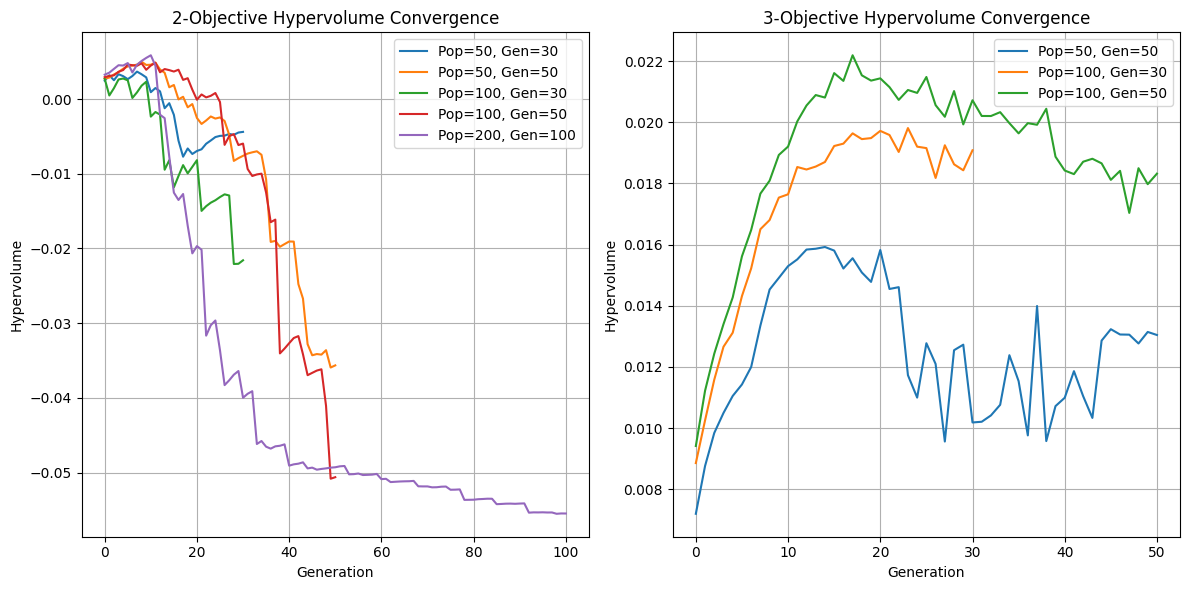

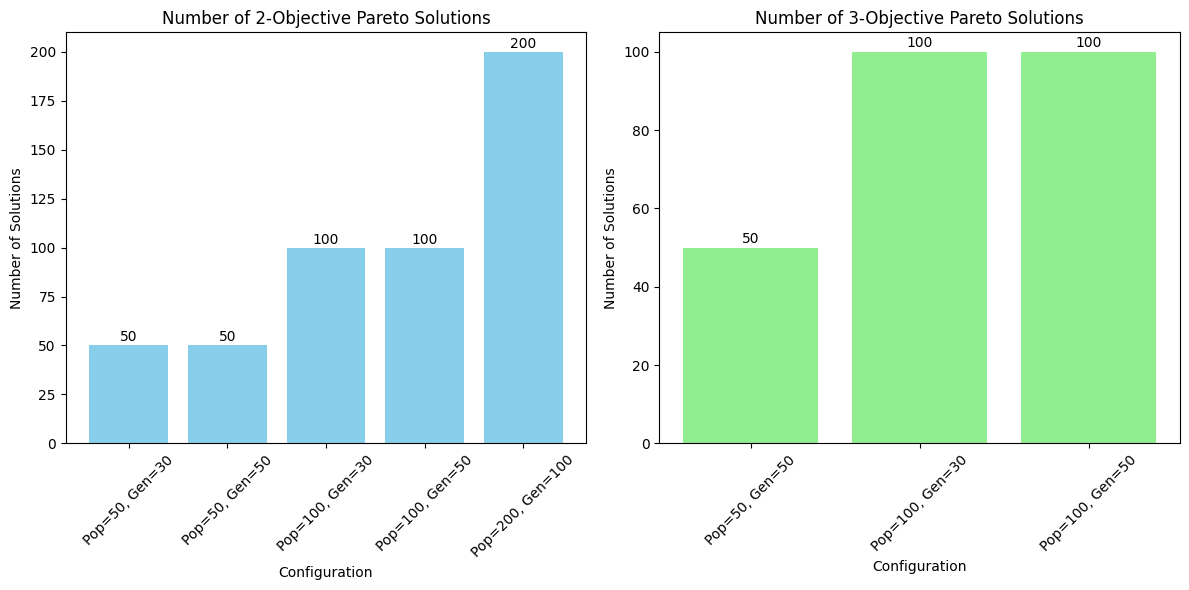


Best 2-objective configuration: Pop=50, Gen=30
Hypervolume: -0.004393
Number of solutions: 50


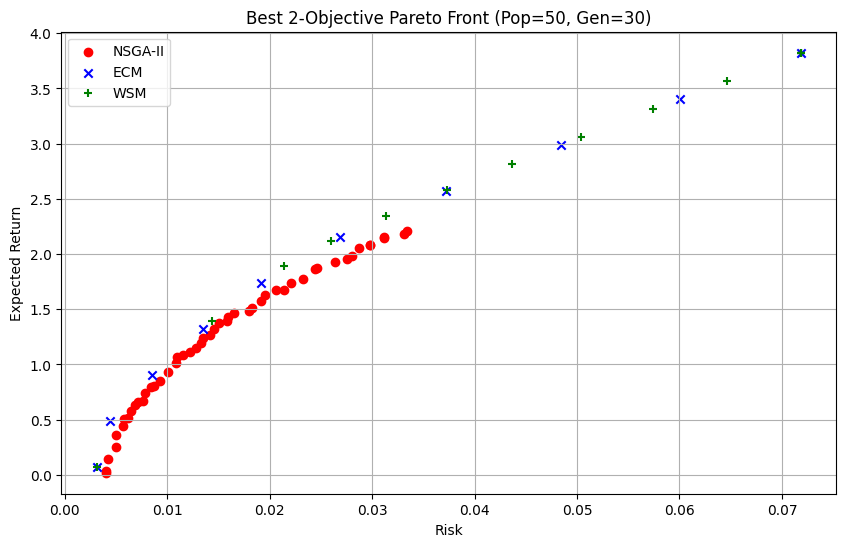


Best 3-objective configuration: Pop=100, Gen=30
Hypervolume: 0.019085
Number of solutions: 100


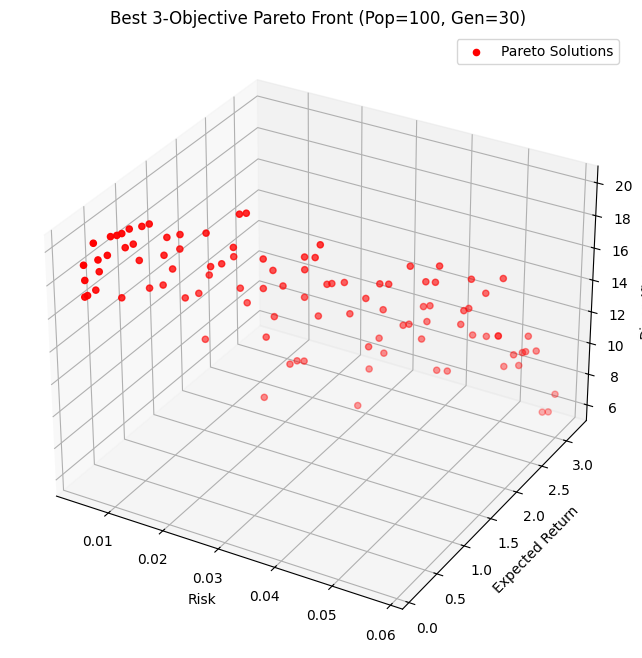


Comparison with classical methods:
NSGA-II (best): 50 solutions
ECM: 10 solutions
WSM: 15 solutions

NSGA-II objective ranges:
Return: 0.0194 to 2.2047
Risk: 0.003996 to 0.033383

ECM objective ranges:
Return: 0.0733 to 3.8238
Risk: 0.003115 to 0.071865

Running multiple times with the best configuration...
Run 1/3
Generation 10/30 completed
Generation 20/30 completed
Generation 30/30 completed
Run 1 completed in 4.06 seconds
Final hypervolume: -0.006751
Final IGD: 0.358172
Number of Pareto optimal solutions: 50
Run 2/3
Generation 10/30 completed
Generation 20/30 completed
Generation 30/30 completed
Run 2 completed in 3.62 seconds
Final hypervolume: -0.022826
Final IGD: 0.168858
Number of Pareto optimal solutions: 50
Run 3/3
Generation 10/30 completed
Generation 20/30 completed
Generation 30/30 completed
Run 3 completed in 3.44 seconds
Final hypervolume: -0.018180
Final IGD: 0.234506
Number of Pareto optimal solutions: 50


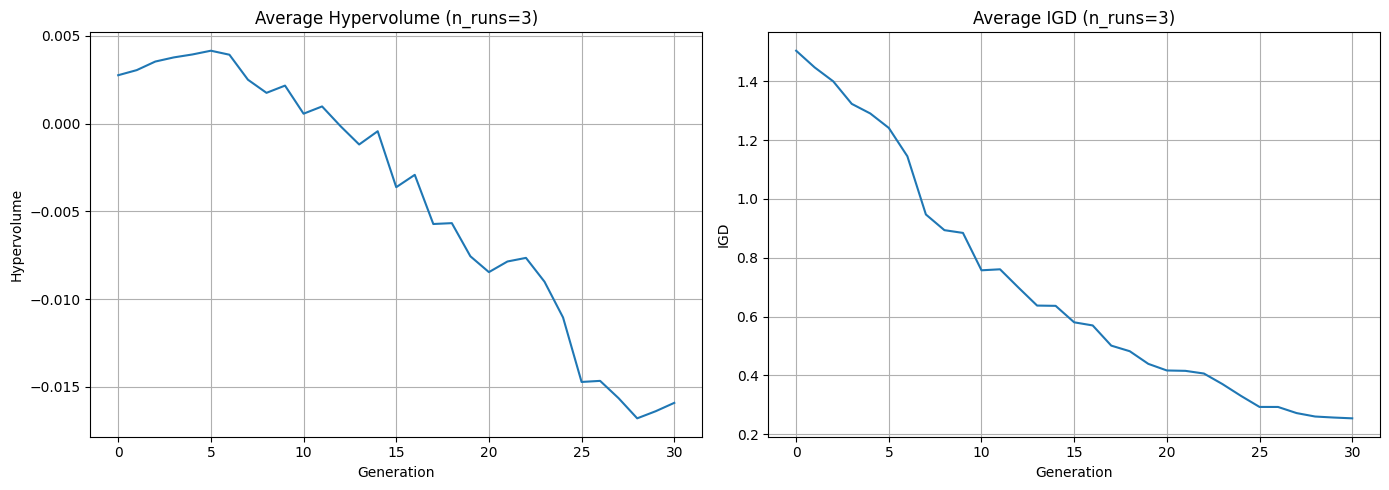

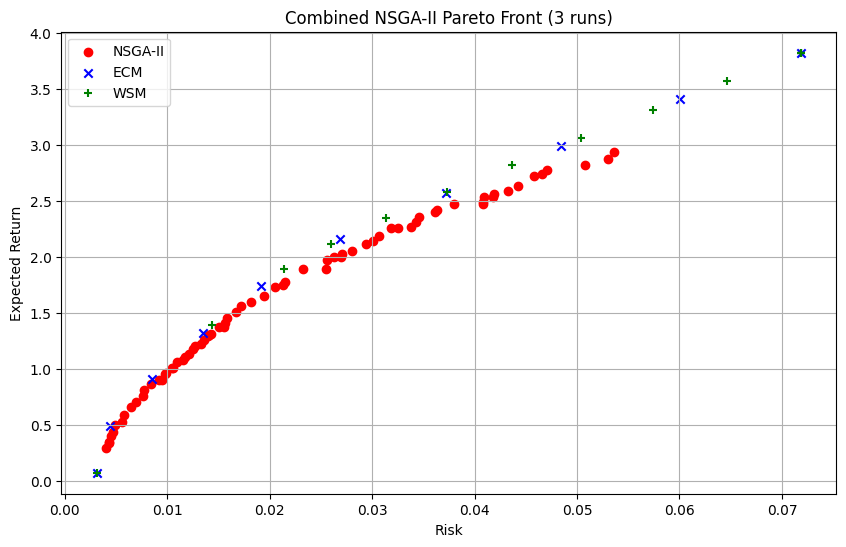

In [7]:
# Verify ECM and WSM solutions exist
if 'ecm_solutions' not in globals() or ecm_solutions is None:
    print("No ECM solutions found. Creating empty list.")
    ecm_solutions = []

if 'wsm_solutions' not in globals() or wsm_solutions is None:
    print("No WSM solutions found. Creating empty list.")
    wsm_solutions = []

# Run experiments with different population sizes and generations
print("=" * 80)
print("Running NSGA-II experiments with different settings")
print("=" * 80)

# Experiment configurations
pop_sizes = [50, 100, 200]
generation_counts = [30, 50, 100]

all_results_2obj = {}
all_results_3obj = {}

# Test smaller configurations first (faster experiments)
for pop_size in pop_sizes[:2]:
    for gen_count in generation_counts[:2]:
        config_name = f"Pop={pop_size}, Gen={gen_count}"
        print(f"\nRunning 2-objective with {config_name}")
        
        # 2-objective case
        nsga2_2obj = NSGA2(
            n_assets=n_assets,
            expected_returns=expected_returns,
            cov_matrix=cov_matrix,
            pop_size=pop_size,
            max_gen=gen_count,
            crossover_prob=0.9,
            mutation_prob=0.1,
            n_objectives=2
        )
        
        # Run NSGA-II
        population_2obj = nsga2_2obj.run(track_metrics=True, ecm_solutions=ecm_solutions)
        pareto_front_2obj = nsga2_2obj.get_pareto_front(population_2obj)
        
        # Store results
        all_results_2obj[config_name] = {
            'nsga2': nsga2_2obj,
            'population': population_2obj,
            'pareto_front': pareto_front_2obj,
            'hypervolume': nsga2_2obj.hypervolume_history[-1] if nsga2_2obj.hypervolume_history else 0,
            'igd': nsga2_2obj.igd_history[-1] if nsga2_2obj.igd_history else 0,
            'num_solutions': len(pareto_front_2obj)
        }
        
        print(f"Found {len(pareto_front_2obj)} Pareto-optimal solutions")
        print(f"Final hypervolume: {nsga2_2obj.hypervolume_history[-1] if nsga2_2obj.hypervolume_history else 0:.6f}")

        # 3-objective case for a few key configurations
        if pop_size == 100 or gen_count == 50:
            print(f"\nRunning 3-objective with {config_name}")
            nsga2_3obj = NSGA2(
                n_assets=n_assets,
                expected_returns=expected_returns,
                cov_matrix=cov_matrix,
                pop_size=pop_size,
                max_gen=gen_count,
                crossover_prob=0.9,
                mutation_prob=0.1,
                n_objectives=3
            )
            
            # Run NSGA-II
            population_3obj = nsga2_3obj.run(track_metrics=True)
            pareto_front_3obj = nsga2_3obj.get_pareto_front(population_3obj)
            
            # Store results
            all_results_3obj[config_name] = {
                'nsga2': nsga2_3obj,
                'population': population_3obj,
                'pareto_front': pareto_front_3obj,
                'hypervolume': nsga2_3obj.hypervolume_history[-1] if nsga2_3obj.hypervolume_history else 0,
                'num_solutions': len(pareto_front_3obj)
            }
            
            print(f"Found {len(pareto_front_3obj)} Pareto-optimal solutions")
            print(f"Final hypervolume: {nsga2_3obj.hypervolume_history[-1] if nsga2_3obj.hypervolume_history else 0:.6f}")

# Try larger configurations for better results
if len(pop_sizes) > 2 and len(generation_counts) > 2:
    config_name = f"Pop={pop_sizes[2]}, Gen={generation_counts[2]}"
    print(f"\nRunning 2-objective with {config_name}")
    
    # 2-objective case with largest settings
    nsga2_2obj_large = NSGA2(
        n_assets=n_assets,
        expected_returns=expected_returns,
        cov_matrix=cov_matrix,
        pop_size=pop_sizes[2],
        max_gen=generation_counts[2],
        crossover_prob=0.9,
        mutation_prob=0.1,
        n_objectives=2
    )
    
    # Run NSGA-II
    population_2obj_large = nsga2_2obj_large.run(track_metrics=True, ecm_solutions=ecm_solutions)
    pareto_front_2obj_large = nsga2_2obj_large.get_pareto_front(population_2obj_large)
    
    # Store results
    all_results_2obj[config_name] = {
        'nsga2': nsga2_2obj_large,
        'population': population_2obj_large,
        'pareto_front': pareto_front_2obj_large,
        'hypervolume': nsga2_2obj_large.hypervolume_history[-1] if nsga2_2obj_large.hypervolume_history else 0,
        'igd': nsga2_2obj_large.igd_history[-1] if nsga2_2obj_large.igd_history else 0,
        'num_solutions': len(pareto_front_2obj_large)
    }
    
    print(f"Found {len(pareto_front_2obj_large)} Pareto-optimal solutions")
    print(f"Final hypervolume: {nsga2_2obj_large.hypervolume_history[-1] if nsga2_2obj_large.hypervolume_history else 0:.6f}")

# Comparison of hypervolumes across different configurations
plt.figure(figsize=(12, 6))

# Plot 2-objective hypervolume convergence
plt.subplot(1, 2, 1)
for config_name, result in all_results_2obj.items():
    plt.plot(result['nsga2'].hypervolume_history, label=config_name)

plt.title('2-Objective Hypervolume Convergence')
plt.xlabel('Generation')
plt.ylabel('Hypervolume')
plt.legend()
plt.grid(True)

# Plot 3-objective hypervolume convergence if available
if all_results_3obj:
    plt.subplot(1, 2, 2)
    for config_name, result in all_results_3obj.items():
        plt.plot(result['nsga2'].hypervolume_history, label=config_name)
    
    plt.title('3-Objective Hypervolume Convergence')
    plt.xlabel('Generation')
    plt.ylabel('Hypervolume')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Comparison of number of Pareto-optimal solutions
config_names_2obj = list(all_results_2obj.keys())
num_solutions_2obj = [all_results_2obj[name]['num_solutions'] for name in config_names_2obj]

plt.figure(figsize=(12, 6))

# Plot 2-objective solution counts
plt.subplot(1, 2, 1)
bars_2obj = plt.bar(config_names_2obj, num_solutions_2obj, color='skyblue')
plt.title('Number of 2-Objective Pareto Solutions')
plt.xlabel('Configuration')
plt.ylabel('Number of Solutions')
plt.xticks(rotation=45)

# Add values on top of the bars
for bar in bars_2obj:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

# Plot 3-objective solution counts if available
if all_results_3obj:
    config_names_3obj = list(all_results_3obj.keys())
    num_solutions_3obj = [all_results_3obj[name]['num_solutions'] for name in config_names_3obj]
    
    plt.subplot(1, 2, 2)
    bars_3obj = plt.bar(config_names_3obj, num_solutions_3obj, color='lightgreen')
    plt.title('Number of 3-Objective Pareto Solutions')
    plt.xlabel('Configuration')
    plt.ylabel('Number of Solutions')
    plt.xticks(rotation=45)
    
    # Add values on top of the bars
    for bar in bars_3obj:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Compare the best Pareto fronts from different configurations

# Get the best 2-objective configuration (highest hypervolume)
best_config_2obj = max(all_results_2obj.items(), key=lambda x: x[1]['hypervolume'])
best_config_name_2obj = best_config_2obj[0]
best_result_2obj = best_config_2obj[1]

print(f"\nBest 2-objective configuration: {best_config_name_2obj}")
print(f"Hypervolume: {best_result_2obj['hypervolume']:.6f}")
print(f"Number of solutions: {best_result_2obj['num_solutions']}")

# Plot the best 2-objective Pareto front
best_result_2obj['nsga2'].plot_2d_pareto_front(
    best_result_2obj['pareto_front'],
    title=f"Best 2-Objective Pareto Front ({best_config_name_2obj})",
    ecm_solutions=ecm_solutions,
    wsm_solutions=wsm_solutions
)

# Get the best 3-objective configuration if available
if all_results_3obj:
    best_config_3obj = max(all_results_3obj.items(), key=lambda x: x[1]['hypervolume'])
    best_config_name_3obj = best_config_3obj[0]
    best_result_3obj = best_config_3obj[1]
    
    print(f"\nBest 3-objective configuration: {best_config_name_3obj}")
    print(f"Hypervolume: {best_result_3obj['hypervolume']:.6f}")
    print(f"Number of solutions: {best_result_3obj['num_solutions']}")
    
    # Plot the best 3-objective Pareto front
    best_result_3obj['nsga2'].plot_3d_pareto_front(
        best_result_3obj['pareto_front'],
        title=f"Best 3-Objective Pareto Front ({best_config_name_3obj})"
    )

# Compare with classical methods
if len(ecm_solutions) > 0 or len(wsm_solutions) > 0:
    print("\nComparison with classical methods:")
    print(f"NSGA-II (best): {best_result_2obj['num_solutions']} solutions")
    print(f"ECM: {len(ecm_solutions)} solutions")
    print(f"WSM: {len(wsm_solutions)} solutions")
    
    # Calculate effective ranges
    pareto_front_best = best_result_2obj['pareto_front']
    if pareto_front_best:
        obj_best = np.array([ind['objectives'] for ind in pareto_front_best])
        returns_best = -obj_best[:, 0]
        risks_best = obj_best[:, 1]
        
        print("\nNSGA-II objective ranges:")
        print(f"Return: {np.min(returns_best):.4f} to {np.max(returns_best):.4f}")
        print(f"Risk: {np.min(risks_best):.6f} to {np.max(risks_best):.6f}")
    
    if len(ecm_solutions) > 0:
        ecm_returns = [sol[1] for sol in ecm_solutions]
        ecm_risks = [sol[2] for sol in ecm_solutions]
        
        print("\nECM objective ranges:")
        print(f"Return: {np.min(ecm_returns):.4f} to {np.max(ecm_returns):.4f}")
        print(f"Risk: {np.min(ecm_risks):.6f} to {np.max(ecm_risks):.6f}")

# Run multiple times and combine results for the best configuration
print("\nRunning multiple times with the best configuration...")
avg_hv_history, avg_igd_history, all_pareto_fronts = run_nsga2_multiple(
    n_assets=n_assets,
    expected_returns=expected_returns,
    cov_matrix=cov_matrix,
    pop_size=int(best_config_name_2obj.split('=')[1].split(',')[0]),  # Extract pop_size from config name
    max_gen=int(best_config_name_2obj.split('=')[2]),  # Extract max_gen from config name
    n_runs=3,  # Reduced runs for demonstration
    n_objectives=2,
    ecm_solutions=ecm_solutions,
    wsm_solutions=wsm_solutions
)

# Combine results from multiple runs
combined_front = combine_pareto_fronts(all_pareto_fronts)

# Create visualization instance
nsga2_vis = NSGA2(
    n_assets=n_assets,
    expected_returns=expected_returns,
    cov_matrix=cov_matrix,
    n_objectives=2
)

# Plot combined front
nsga2_vis.plot_2d_pareto_front(
    combined_front,
    title="Combined NSGA-II Pareto Front (3 runs)",
    ecm_solutions=ecm_solutions,
    wsm_solutions=wsm_solutions
)

Finding the Best Portfolio Solution

BEST Portfolio (Maximum Sharpe Ratio):
Return: 0.8121, Risk: 0.007748
Sharpe Ratio: 104.8155


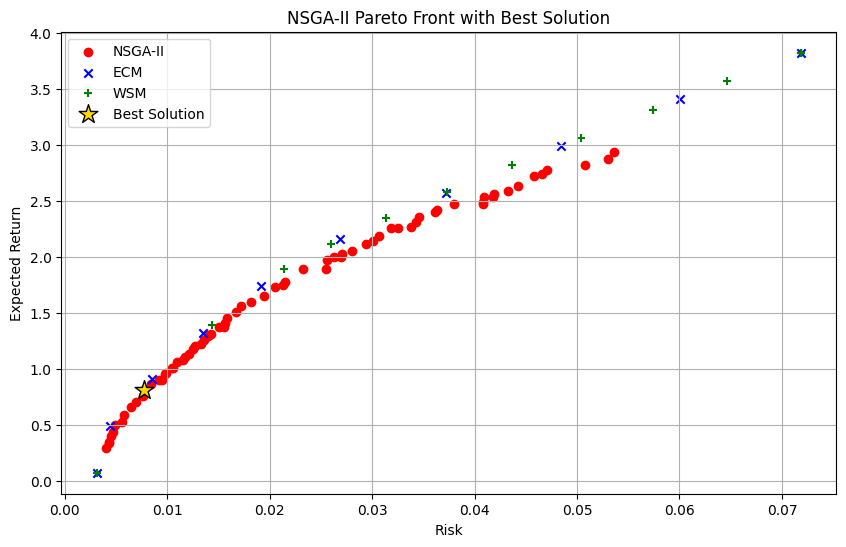


STEP 1: Reordering weights to match the required asset order...
✓ All required assets found in the data
Sum of weights: 1.0000000000
✓ Weights sum to exactly 1.0

STEP 2: Saving solution to file...
Solution exported to 151958_151960.txt

STEP 3: Verifying file contents...
✓ File has correct format: return risk weight1 weight2 ... weight20

STEP 4: Visualizing the best portfolio...


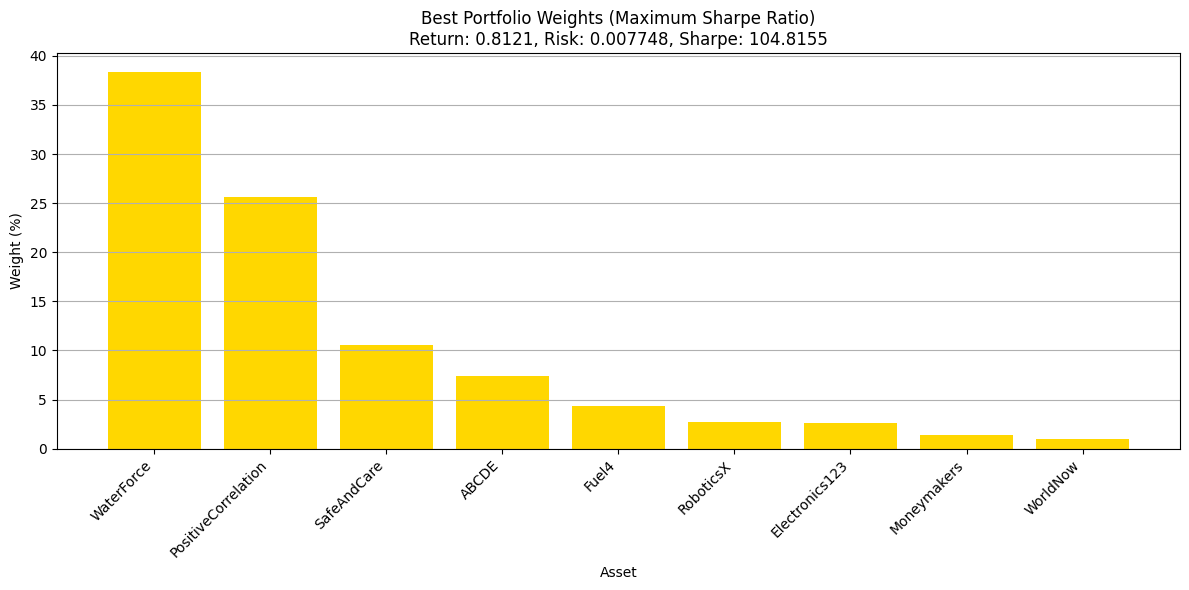


Weights in the required order (as saved in the file):
1. SuperFuture: 0.006455
2. Apples: 0.003186
3. WorldNow: 0.010033
4. Electronics123: 0.026051
5. Photons: 0.000921
6. SpaceNow: 0.009815
7. PearPear: 0.002887
8. PositiveCorrelation: 0.256534
9. BetterTechnology: 0.009509
10. ABCDE: 0.074295
11. EnviroLike: 0.002688
12. Moneymakers: 0.013642
13. Fuel4: 0.043234
14. MarsProject: 0.007259
15. CPU-XYZ: 0.004342
16. RoboticsX: 0.027303
17. Lasers: 0.002933
18. WaterForce: 0.383610
19. SafeAndCare: 0.105933
20. BetterTomorrow: 0.009370


In [8]:
# Find the best portfolio solution and export to text file
print("=" * 80)
print("Finding the Best Portfolio Solution")
print("=" * 80)

# Define the required asset order exactly as specified in the PDF
required_order = [
    "SuperFuture", "Apples", "WorldNow", "Electronics123", "Photons",
    "SpaceNow", "PearPear", "PositiveCorrelation", "BetterTechnology", "ABCDE",
    "EnviroLike", "Moneymakers", "Fuel4", "MarsProject", "CPU-XYZ",
    "RoboticsX", "Lasers", "WaterForce", "SafeAndCare", "BetterTomorrow"
]

# Use the combined front if available, otherwise use the best result from experiments
if 'combined_front' not in globals() or not combined_front:
    print("No combined front available. Using the best result from experiments.")
    if 'best_result_2obj' in globals() and best_result_2obj['pareto_front']:
        combined_front = best_result_2obj['pareto_front']
    else:
        print("No valid Pareto front available.")
        combined_front = []

if combined_front:
    # Create visualization instance
    nsga2_vis = NSGA2(
        n_assets=n_assets,
        expected_returns=expected_returns,
        cov_matrix=cov_matrix,
        n_objectives=2
    )
    
    # Extract objectives
    objectives = np.array([ind['objectives'] for ind in combined_front])
    returns = -objectives[:, 0]
    risks = objectives[:, 1]
    
    # Find the best solution - Maximum Sharpe ratio
    sharpe_ratios = returns / risks
    max_sharpe_idx = np.argmax(sharpe_ratios)
    best_solution = combined_front[max_sharpe_idx]
    
    # Print details of the best solution
    print("\nBEST Portfolio (Maximum Sharpe Ratio):")
    print(f"Return: {returns[max_sharpe_idx]:.4f}, Risk: {risks[max_sharpe_idx]:.6f}")
    print(f"Sharpe Ratio: {sharpe_ratios[max_sharpe_idx]:.4f}")
    
    # Visualize the Pareto front with the best solution highlighted
    nsga2_vis.plot_2d_pareto_front(
        combined_front,
        title="NSGA-II Pareto Front with Best Solution",
        ecm_solutions=ecm_solutions,
        wsm_solutions=wsm_solutions,
        best_solution=best_solution
    )
    
    # STEP 1: First reorder the weights to match the required order
    print("\nSTEP 1: Reordering weights to match the required asset order...")
    
    # Create mapping from asset names to weights
    weights_dict = {name: weight for name, weight in zip(asset_names, best_solution['weights'])}
    
    # Verify all required assets exist in our data
    missing_assets = [asset for asset in required_order if asset not in weights_dict]
    if missing_assets:
        print(f"ERROR: Missing assets in our data: {missing_assets}")
    else:
        print("✓ All required assets found in the data")
    
    # Reorder weights according to required order
    ordered_weights = [weights_dict[asset] for asset in required_order]
    
    # Verify the weights sum to 1.0
    total_weight = np.sum(ordered_weights)
    print(f"Sum of weights: {total_weight:.10f}")
    assert abs(total_weight - 1.0) < 1e-10, "Weights must sum to exactly 1.0"
    print("✓ Weights sum to exactly 1.0")
    
    # STEP 2: Save to file in the format specified in the PDF
    print("\nSTEP 2: Saving solution to file...")
    filename = "151958_151960.txt"
    
    # Extract the data to export
    expected_return = returns[max_sharpe_idx]
    expected_risk = risks[max_sharpe_idx]
    
    # Create the line to write to the file (using dots for decimal points as specified)
    line = f"{expected_return:.4f} {expected_risk:.4f}"
    for weight in ordered_weights:
        line += f" {weight:.6f}"
    
    # Write to the file
    with open(filename, 'w') as f:
        f.write(line)
    print(f"Solution exported to {filename}")
    
    # STEP 3: Verify the file was saved correctly
    print("\nSTEP 3: Verifying file contents...")
    with open(filename, 'r') as f:
        saved_content = f.read().strip()
    
    # Verify the number of elements in the saved line
    elements = saved_content.split()
    assert len(elements) == 22, f"Expected 22 elements (2 + 20 weights), found {len(elements)}"
    print("✓ File has correct format: return risk weight1 weight2 ... weight20")
    
    # Verify the weights in the file sum to 1
    saved_weights = [float(element) for element in elements[2:]]
    
    # STEP 4: Visualize the best portfolio weights
    print("\nSTEP 4: Visualizing the best portfolio...")
    significant_weights = [(asset, weight) for asset, weight in zip(required_order, saved_weights) if weight > 0.01]
    significant_weights.sort(key=lambda x: x[1], reverse=True)
    
    # Plot as a bar chart
    plt.figure(figsize=(12, 6))
    assets = [item[0] for item in significant_weights]
    weights = [item[1] * 100 for item in significant_weights]
    
    bars = plt.bar(assets, weights, color='gold')
    plt.xlabel('Asset')
    plt.ylabel('Weight (%)')
    plt.title(f"Best Portfolio Weights (Maximum Sharpe Ratio)\nReturn: {expected_return:.4f}, Risk: {expected_risk:.6f}, Sharpe: {sharpe_ratios[max_sharpe_idx]:.4f}")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    # Print the weights in the specified order
    print("\nWeights in the required order (as saved in the file):")
    for i, asset_name in enumerate(required_order):
        print(f"{i+1}. {asset_name}: {saved_weights[i]:.6f}")
else:
    print("No Pareto front available for analysis.")

# SAME AS ABOVE BUT DIFFERENTIATED